In [1]:
args_cuda = 0
args_gpu = False

In [2]:
if args_gpu: 
    import setGPU
    args_cuda = 1
import os
import numpy as np
import h5py
import glob
import itertools
import sys
from sklearn.utils import shuffle

import torch
import torch.nn as nn
from torch.autograd.variable import *
import torch.optim as optim

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../python/sonic.mplstyle')

In [4]:
# define the pytorch model
class GraphNet(nn.Module):
    def __init__(self, n_constituents, n_targets, params, hidden, De, Do, 
                 fr_activation=0, fo_activation=0, fc_activation=0, optimizer = 0, verbose = False):
        super(GraphNet, self).__init__()
        self.hidden = hidden
        self.P = len(params)
        self.N = n_constituents
        self.Nr = self.N * (self.N - 1)
        self.Dr = 0
        self.De = De
        self.Dx = 0
        self.Do = Do
        self.n_targets = n_targets
        self.fr_activation = fr_activation
        self.fo_activation = fo_activation
        self.fc_activation = fc_activation
        self.optimizer = optimizer
        self.verbose = verbose
        self.assign_matrices()

        self.Ra = torch.ones(self.Dr, self.Nr)
        self.fr1 = nn.Linear(2 * self.P + self.Dr, hidden)
        self.fr2 = nn.Linear(hidden, int(hidden/2))
        self.fr3 = nn.Linear(int(hidden/2), self.De)
        self.fo1 = nn.Linear(self.P + self.Dx + self.De, hidden)
        self.fo2 = nn.Linear(hidden, int(hidden/2))
        self.fo3 = nn.Linear(int(hidden/2), self.Do)
        self.fc1 = nn.Linear(self.Do, hidden)
        self.fc2 = nn.Linear(hidden, int(hidden/2))
        self.fc3 = nn.Linear(int(hidden/2), self.n_targets)

    def assign_matrices(self):
        self.Rr = torch.zeros(self.N, self.Nr)
        self.Rs = torch.zeros(self.N, self.Nr)
        receiver_sender_list = [i for i in itertools.product(range(self.N), range(self.N)) if i[0]!=i[1]]
        for i, (r, s) in enumerate(receiver_sender_list):
            self.Rr[r, i] = 1
            self.Rs[s, i] = 1
        self.Rr = Variable(self.Rr)
        self.Rs = Variable(self.Rs)

    def forward(self, x):
        Orr = self.tmul(x, self.Rr)
        Ors = self.tmul(x, self.Rs)
        B = torch.cat([Orr, Ors], 1)
        ### First MLP ###
        B = torch.transpose(B, 1, 2).contiguous()
        if self.fr_activation ==2:
            B = nn.functional.selu(self.fr1(B.view(-1, 2 * self.P + self.Dr)))
            B = nn.functional.selu(self.fr2(B))
            E = nn.functional.selu(self.fr3(B).view(-1, self.Nr, self.De))            
        elif self.fr_activation ==1:
            B = nn.functional.elu(self.fr1(B.view(-1, 2 * self.P + self.Dr)))
            B = nn.functional.elu(self.fr2(B))
            E = nn.functional.elu(self.fr3(B).view(-1, self.Nr, self.De))
        else:
            B = nn.functional.relu(self.fr1(B.view(-1, 2 * self.P + self.Dr)))
            B = nn.functional.relu(self.fr2(B))
            E = nn.functional.relu(self.fr3(B).view(-1, self.Nr, self.De))
        del B
        E = torch.transpose(E, 1, 2).contiguous()
        Ebar = self.tmul(E, torch.transpose(self.Rr, 0, 1).contiguous())
        del E
        C = torch.cat([x, Ebar], 1)
        del Ebar
        C = torch.transpose(C, 1, 2).contiguous()
        ### Second MLP ###
        if self.fo_activation ==2:
            C = nn.functional.selu(self.fo1(C.view(-1, self.P + self.Dx + self.De)))
            C = nn.functional.selu(self.fo2(C))
            O = nn.functional.selu(self.fo3(C).view(-1, self.N, self.Do))
        elif self.fo_activation ==1:
            C = nn.functional.elu(self.fo1(C.view(-1, self.P + self.Dx + self.De)))
            C = nn.functional.elu(self.fo2(C))
            O = nn.functional.elu(self.fo3(C).view(-1, self.N, self.Do))
        else:
            C = nn.functional.relu(self.fo1(C.view(-1, self.P + self.Dx + self.De)))
            C = nn.functional.relu(self.fo2(C))
            O = nn.functional.relu(self.fo3(C).view(-1, self.N, self.Do))
        del C
        ## sum over the O matrix  
        O = torch.sum( O, dim=1)
        ### Classification MLP ###
        if self.fc_activation ==2:
            N = nn.functional.selu(self.fc1(O.view(-1, self.Do)))
            N = nn.functional.selu(self.fc2(N))       
        elif self.fc_activation ==1:
            N = nn.functional.elu(self.fc1(O.view(-1, self.Do)))
            N = nn.functional.elu(self.fc2(N))
        else:
            N = nn.functional.relu(self.fc1(O.view(-1, self.Do)))
            N = nn.functional.relu(self.fc2(N))
        #N = nn.functional.relu(self.fc3(N))
        N = self.fc3(N)
        return N, O

    def tmul(self, x, y):  #Takes (I * J * K)(K * L) -> I * J * L 
        x_shape = x.size()
        y_shape = y.size()
        return torch.mm(x.view(-1, x_shape[2]), y).view(-1, x_shape[1], y_shape[1])

In [5]:
# optimal parameters
nParticles = 150
x = []
x.append(50) # hinned nodes                                                                                                                                            
x.append(14) # De                                                                                                                                                      
x.append(12) # Do                                                                                                                                                      
x.append(2) # fr_activation_index                                                                                                                                      
x.append(2) # fo_activation_index                                                                                                                                      
x.append(2) # fc_activation_index                                                                                                                                      
x.append(0) # optmizer_index                  

In [6]:
labels = ['j_g', 'j_q', 'j_w', 'j_z', 'j_t']
classes = ['gluons', 'quarks', 'W','Z', 'top']
params = ['j1_px', 'j1_py' , 'j1_pz' , 'j1_e' , 'j1_erel' , 'j1_pt' , 'j1_ptrel', 'j1_eta' , 'j1_etarel' ,
          'j1_etarot' , 'j1_phi' , 'j1_phirel' , 'j1_phirot', 'j1_deltaR' , 'j1_costheta' , 'j1_costhetarel']

In [7]:
val_split = 0.3
batch_size = 100
n_epochs = 100
patience = 10

In [8]:
import glob
inputValFiles = glob.glob("../data/jetImage*_%sp*.h5" %nParticles)

In [9]:
mymodel = GraphNet(nParticles, len(labels), params, int(x[0]), int(x[1]), int(x[2]),
                   int(x[3]),  int(x[4]),  int(x[5]), int(x[6]), 0)
mymodel.load_state_dict(torch.load("../models/IN_150_withSumO.params", map_location='cpu'))
mymodel.eval()

GraphNet(
  (fr1): Linear(in_features=32, out_features=50, bias=True)
  (fr2): Linear(in_features=50, out_features=25, bias=True)
  (fr3): Linear(in_features=25, out_features=14, bias=True)
  (fo1): Linear(in_features=30, out_features=50, bias=True)
  (fo2): Linear(in_features=50, out_features=25, bias=True)
  (fo3): Linear(in_features=25, out_features=12, bias=True)
  (fc1): Linear(in_features=12, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=5, bias=True)
)

In [36]:
# HLF  in classifier
myHLFlist = [12, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 48, 52]
namesY = ['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 
          'd2_b1_mmdt', 'd2_b2_mmdt','d2_a1_b2_mmdt', 'm2_b1_mmdt', 
          'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
labelsY = ['$\Sigma zlog(z)$', '$C_{1}^{0}$', '$C_{1}^{1}$', '$C_{1}^{2}$',
          '$C_{2}^{1}$', '$C_{2}^{2}$',
         '$D_{2}^{1}$','$D_{2}^{2}$',
          '$D_{2}^{(1,2)}$', 
         '$M_{2}^{1}$', '$M_{2}^{2}$',
         '$N_{2}^{1}$', '$N_{2}^{2}$', 'jet $m_{mMDT}$', 'Multiplicity']

In [43]:
# other HLF: all
myHLFlist = [4,26,7,29,
             5,27,8,30,
             6,28,9,31]
namesY = ['j_tau1_b1', 'j_tau1_b1_mmdt','j_tau1_b2',  'j_tau1_b2_mmdt', 
          'j_tau2_b1', 'j_tau2_b1_mmdt','j_tau2_b2',  'j_tau2_b2_mmdt', 
          'j_tau3_b1', 'j_tau3_b1_mmdt','j_tau3_b2',  'j_tau3_b2_mmdt']
labelsY = ['$\\tau_1^1$','$\\tau_1^{1,mmdt}$','$\\tau_1^2$','$\\tau_1^{2,mmdt}$',
           '$\\tau_2^1$','$\\tau_2^{1,mmdt}$','$\\tau_2^2$','$\\tau_2^{2,mmdt}$',
           '$\\tau_3^1$','$\\tau_3^{1,mmdt}$','$\\tau_3^2$','$\\tau_3^{2,mmdt}$']

In [373]:
# other HLF: w/o mmdt 
myHLFlist = [4,7,
             5,8,
             6,9]
namesY = ['j_tau1_b1', 'j_tau1_b2',  
          'j_tau2_b1', 'j_tau2_b2', 
          'j_tau3_b1', 'j_tau3_b2']
labelsY = ['$\\tau_1^1$','$\\tau_1^2$',
           '$\\tau_2^1$','$\\tau_2^2$',
           '$\\tau_3^1$','$\\tau_3^2$']

In [358]:
# other HLF: with mmdt 
myHLFlist = [26,29,
             27,30,
             28,31]
namesY = ['j_tau1_b1_mmdt', 'j_tau1_b2_mmdt',  
          'j_tau2_b1_mmdt', 'j_tau2_b2_mmdt', 
          'j_tau3_b1_mmdt', 'j_tau3_b2_mmdt']
labelsY = ['$\\tau_1^{1,mmdt}$','$\\tau_1^{2,mmdt}$',
           '$\\tau_2^{1,mmdt}$','$\\tau_2^{2,mmdt}$',
           '$\\tau_3^{1,mmdt}$','$\\tau_3^{2,mmdt}$']

In [11]:
#read datasets
X = np.array([])                                                                                                                                      
Y = np.array([]) 
Y_hlf = np.array([]) 
for fileIN in inputValFiles:
    if X.shape[0] >10000: continue
    f = h5py.File(fileIN, 'r')                                                                                                                        
    myFeatures = np.array(f.get('jetConstituentList'))                                                                                                
    myTarget = np.array(f.get('jets')[0:,-6:-1])
    myHLF = np.array(f.get('jets'))
    X = np.concatenate([X,myFeatures], axis = 0) if X.size else myFeatures                                                                            
    Y = np.concatenate([Y,myTarget], axis = 0) if Y.size else myTarget                                                                                
    Y_hlf = np.concatenate([Y_hlf,myHLF], axis = 0) if Y_hlf.size else myHLF                                                                                
    print(X.shape, Y.shape, Y_hlf.shape)

(10000, 150, 16) (10000, 5) (10000, 59)


In [12]:
# pre-processing                                                                                                                                
X, Y, Y_hlf = shuffle(X, Y, Y_hlf, random_state=1)
X = np.swapaxes(X, 1, 2)
#Y = np.argmax(Y, axis=1)
X = torch.FloatTensor(X)
Y = torch.FloatTensor(Y)
Y_hlf = torch.FloatTensor(Y_hlf)

In [13]:
# extract the O matrix and the category output [TBF]
predict_test = []
lst = []
Otot = []
for j in torch.split(X, batch_size):
    a, myO = mymodel(j)
    a = a.cpu().data.numpy()
    myO = myO.cpu().data.numpy()
    # sum over particles
    lst.append(a)
    Otot.append(myO)
    
predicted = Variable(torch.FloatTensor(np.concatenate(lst)))
predicted = torch.nn.functional.softmax(predicted, dim=1)
predict_test = predicted.data.numpy()

O_predicted = Variable(torch.FloatTensor(np.concatenate(Otot)))
O_predicted_test = O_predicted.data.numpy()

In [14]:
print(O_predicted.shape)

torch.Size([10000, 12])


No handles with labels found to put in legend.


j_g tagger, auc = 95.4%
j_q tagger, auc = 92.1%
j_w tagger, auc = 96.7%
j_z tagger, auc = 96.3%
j_t tagger, auc = 97.0%


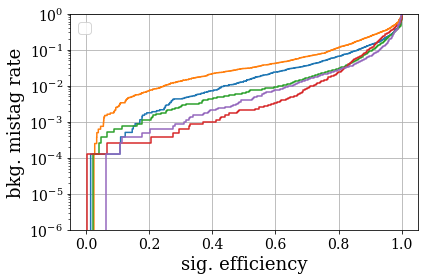

In [15]:
# ROC CURVE
import pandas as pd
from sklearn.metrics import roc_curve, auc
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}
plt.figure()
for i, label in enumerate(labels):
        df[label] = Y[:,i]
        df[label + '_pred'] = predict_test[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])
        print('%s tagger, auc = %.1f%%' %(label,auc1[label]*100.))
        #plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%' %(label,auc1[label]*100.))
        plt.plot(tpr[label],fpr[label])
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='upper left')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))
plt.show()

In [16]:
print(O_predicted_test.shape)
print(Y_hlf.shape)

(10000, 12)
torch.Size([10000, 59])


In [17]:
k = 0

-0.32449002407107647
0.1930157468026006
0.5030825832052169
0.5295094326608085
0.40186684981943754
0.37366675486737083
-0.18474172254667587
-0.20628392494012188
-0.25319267121806327
-0.20940338207859627
-0.19757591830658192
-0.26568318040703526
-0.24000773512780524
0.6381413718833289
0.48119116330882145
-0.540249269791199
0.2752664228554376
0.5266848112108827
0.43542967600302324
0.5567026031162132
0.5137001224377853
-0.0072113115039978476
-0.02056575124033177
-0.023908031387107273
-0.030110365612770244
-0.06298384708942394
-0.0029406236618750373
-0.03361290238115401
0.46446106397087195
0.7624453585263966
-0.679173515502142
0.44689502304046275
0.1778405187677667
0.06343119144076115
0.3049407621096423
0.24334165709646197
0.17910856662173122
0.2045898054649174
0.3809701390479097
0.369841743472654
0.22847732843234828
0.40592057625781175
0.2696869848390866
0.08758115687425577
0.6555667742334702
0.048142836067219405
-0.07602033904513883
-0.3641716424042175
-0.33284125639534523
-0.261337930112

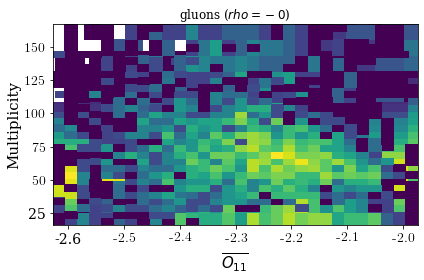

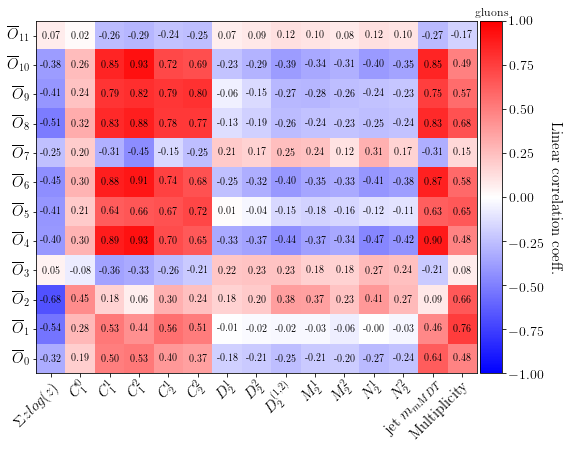

In [18]:
nO = O_predicted_test.shape[1]
myrho = np.zeros([nO,len(labelsY)])
from matplotlib.colors import LogNorm
for i in range(nO):
    xlabel = "$\overline{O_{%i}}$" %i
    myO_predicted_test = O_predicted_test[:,i]/100.
    for j in range(len(labelsY)):
        mask = Y[:,k].data.numpy()
        mask = mask >0
        myY_hlf = Y_hlf.data.numpy()[:,myHLFlist[j]]
        ylabel = labelsY[j]
        plt.hist2d(myO_predicted_test[mask], myY_hlf[mask], bins=30, norm=LogNorm())
        plt.xlabel(xlabel, fontsize=15)
        plt.ylabel(ylabel, fontsize=15)
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        rho = np.corrcoef(myO_predicted_test[mask], myY_hlf[mask])
        print(rho[0,1])
        myrho[i,j] = rho[0,1]
        plt.title('%s ($rho = %2.f$)' %(classes[k],rho[0,1]))
        #plt.show()
        plt.draw()
        plt.savefig('O%i_%s_%s.png' %(i, namesY[j],classes[k]), dpi=250)
    
# drow correlation plot
fig, ax = plt.subplots(figsize=(8, 2*len(labelsY)))

#fig.figure(figsize=(8, 2nO))
#im = ax.imshow(myrho, origin='lower',norm=LogNorm(vmin=0.01), cmap='Blues')
im = ax.imshow(myrho, origin='lower', cmap='bwr', vmin=-1, vmax=1)

# We want to show all ticks...
ax.set_xticks(np.arange(len(labelsY)))
ax.set_yticks(np.arange(nO))
# ... and label them with the respective list entries
labelsO = []
for i in range(nO):
    labelsO.append("$\overline{O}_{%i}$" %i)
ax.set_yticklabels(labelsO, fontsize=15)
ax.set_xticklabels(labelsY, fontsize=15)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
# Loop over data dimensions and create text annotations.
for i in range(nO):
    for j in range(len(labelsY)):
        text = plt.text(j, i, "%.2f" %myrho[i, j], ha="center", va="center", color="black")
        
# Create colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

#cbar = ax.figure.colorbar(im, ax=ax, cmap="binary")
cbar = ax.figure.colorbar(im, cax=cax, cmap='Blues')
cbar.ax.set_ylabel("Linear correlation coeff.", rotation=-90, va="bottom", fontsize=15)
plt.title('%s' %classes[k])
plt.draw()
plt.savefig('rho_%s.png' %(classes[k]), dpi=250)

In [48]:
#i_O = 1
#i_Tau = -1

#i_O = 9
#i_Tau = -2
#i_O = 4
#i_Tau = 2
i_O = 2
i_Tau = -4

In [49]:
ylabel = labelsY[i_Tau]
for iClass in range(5):
    mask = Y[:,iClass].data.numpy()
    mask = mask >0
    # make 2D plot
    xlabel = "$\overline{O_{%i}}$" %i_O
    myO_predicted_test = O_predicted_test[:,i_O]/100.
    myY_hlf = Y_hlf.data.numpy()[:,myHLFlist[i_Tau]]
    rho = np.corrcoef(myO_predicted_test[mask], myY_hlf[mask])
    print(rho[0,1])
    plt.figure(figsize=(7, 7))
    plt.hist2d(myO_predicted_test[mask], myY_hlf[mask], bins=30, norm=LogNorm(), cmap='PuBu_r')
    plt.xlabel(xlabel, fontsize=30)
    plt.ylabel(ylabel, fontsize=30)
    plt.title("%s ($\\rho = %.2f$)" %(classes[iClass], rho[0,1]), fontsize=30)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    myrho[i,j] = rho[0,1]
    #plt.legend(xlabel, '$rho_{corr} = %f$' %rho[1,1])
    #plt.show()
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=30)
    plt.draw()
    plt.savefig('O%i_corr_%s.pdf' %(i_O, classes[iClass]), dpi=500)
    plt.close()

0.5041582373578781
0.6855034160923847
0.7620900507638361
0.7433927131761713
0.5647613285515743
